Image Reconstruction

Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates (X, Y) to the pixel colors (R, G, B). Here, (X, Y) represents the coordinates of the pixels, and (R, G, B) represents the color values at those coordinates.

1. **Load Image**: Select any image of your choice.
2. **Random Fourier Features (RFF)**: Implement RFF to map pixel coordinates to color values.
3. **Linear Regression**: Use linear regression to learn the mapping.
4. **Display Results**: Show both the original and reconstructed images.
5. **Metrics**: Calculate the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.

**Key Variables**:
- X, Y: Pixel coordinates.
- R, G, B: Pixel color values.


## Importing necessary libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

print("Import Completed")

# import sys
# sys.path.append("..")
# from latexify import latexify, format_axes


Device:  cpu
Import Completed


In [ ]:
# # Watermark code to print library versions
# import watermark
# %load_ext watermark
# %watermark -n -v -m -g -b -t -p torch,torchvision,numpy,pandas,matplotlib,einops,matplotlib

In [ ]:
# Set the random seed for reproducibility
torch.manual_seed(42)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")

## Importing image

In [ ]:
import os

# Define the directory path
directory_path = '../assets/images/'

# Check if the directory exists, and create it if it does not
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Check if the file exists
if os.path.exists(os.path.join(directory_path, 'iitgn.jpeg')):
    print('iitgn.jpeg exists')
else:
    # Download the file if it does not exist
#     !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O ../assets/images/dog.jpg
#     !wget https://campus.iitgn.ac.in/gallery/academic_area/data1/images/central_samvad_in_the_academic_spine.jpg -O ../assets/images/iitgn.jpg

    !wget https://news.iitgn.ac.in/wp/wp-content/uploads/2024/06/IITGN-campus-3-2.jpeg -O ../assets/images/iitgn.jpg
print("Download Successful!")

--2024-09-19 19:45:07--  https://news.iitgn.ac.in/wp/wp-content/uploads/2024/06/IITGN-campus-3-2.jpeg
Resolving news.iitgn.ac.in (news.iitgn.ac.in)... 192.185.129.4
Connecting to news.iitgn.ac.in (news.iitgn.ac.in)|192.185.129.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238762 (233K) [image/jpeg]
Saving to: ‘../assets/images/iitgn.jpg’

../assets/images/ii 100%[===================>] 233.17K  --.-KB/s    in 0.1s    

2024-09-19 19:45:07 (2.29 MB/s) - ‘../assets/images/iitgn.jpg’ saved [238762/238762]

Download Successful!


In [ ]:
# Read in a image from torchvision
img = torchvision.io.read_image("../assets/images/iitgn.jpg")
print(img.shape)

torch.Size([3, 600, 900])


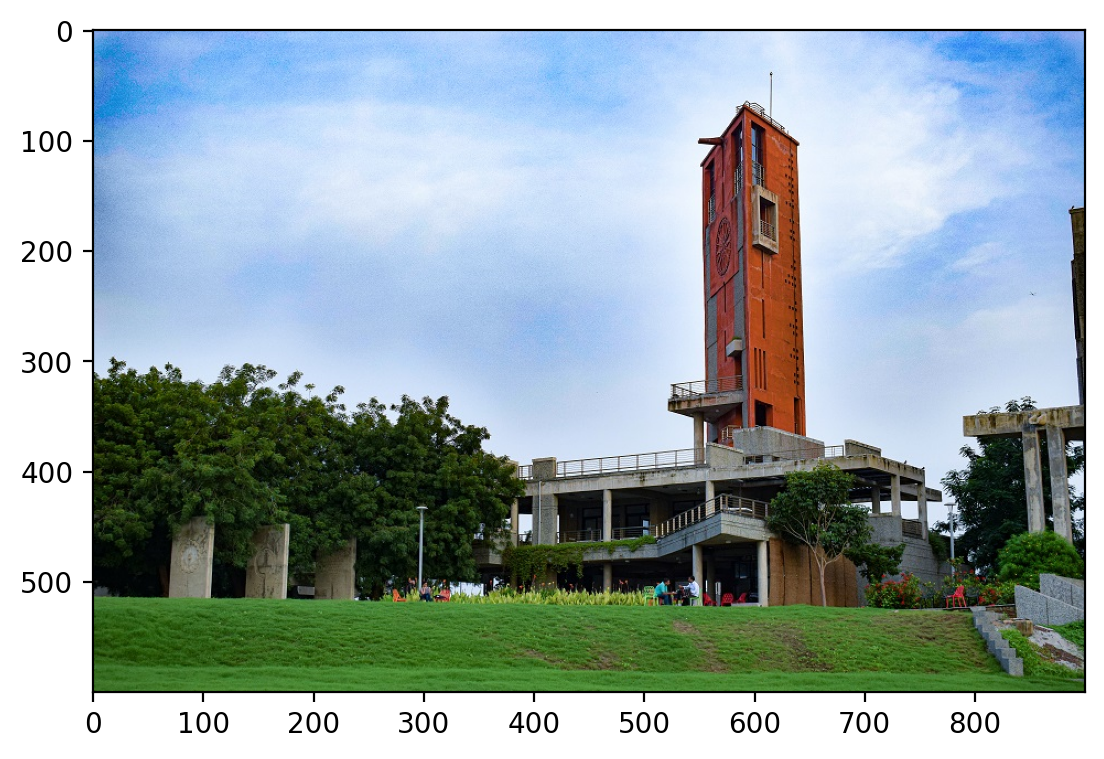

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
# plt.axis('off')
plt.show()

In [ ]:
from sklearn import preprocessing
# scaling the image tensor
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
# apply the fitted scalar to the reshaped image  , and then reshape back to the original dimensions
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)
img_scaled = torch.tensor(img_scaled)

(3, 600, 900)


In [ ]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.5412, 0.5333, 0.4863,  ..., 0.5451, 0.5608, 0.5412],
         [0.5059, 0.5373, 0.5059,  ..., 0.5647, 0.5451, 0.5451],
         [0.5412, 0.5333, 0.5098,  ..., 0.5647, 0.5216, 0.5373],
         ...,
         [0.2627, 0.2941, 0.2549,  ..., 0.2314, 0.2157, 0.1843],
         [0.1647, 0.1647, 0.1882,  ..., 0.2314, 0.2196, 0.2078],
         [0.2039, 0.2275, 0.2588,  ..., 0.2157, 0.2039, 0.2157]],

        [[0.6902, 0.6902, 0.6667,  ..., 0.6667, 0.6824, 0.6627],
         [0.6549, 0.6941, 0.6667,  ..., 0.6863, 0.6667, 0.6667],
         [0.6784, 0.6706, 0.6471,  ..., 0.6863, 0.6431, 0.6588],
         ...,
         [0.4667, 0.4980, 0.4588,  ..., 0.4157, 0.4000, 0.3686],
         [0.3647, 0.3647, 0.3882,  ..., 0.4157, 0.4039, 0.3922],
         [0.4039, 0.4275, 0.4588,  ..., 0.4000, 0.3882, 0.4000]],

        [[0.9333, 0.9294, 0.9020,  ..., 0.9294, 0.9451, 0.9255],
         [0.8980, 0.9333, 0.9098,  ..., 0.9490, 0.9294, 0.9294],
         [0.9294, 0.9216, 0.9059,  ..., 0.9412, 0.8980, 0.

## Crop the image

In [ ]:
# Functional Crop
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 150, 300, 400, 400)
crop.shape

# # Center crop
# center_crop = torchvision.transforms.CenterCrop(300)  # Crop to a 300x300 square
# crop = center_crop(img_scaled.cpu())
# print(crop.shape)


torch.Size([3, 400, 400])

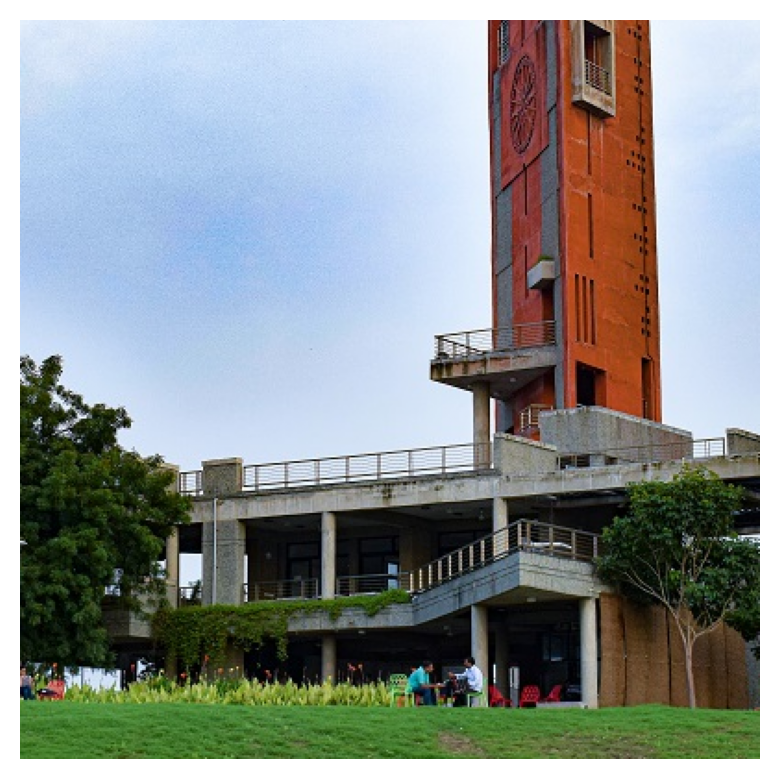

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
plt.axis('off')
plt.show()

In [ ]:
crop = crop.to(device)

In [ ]:
import torch.nn.functional
resized_crop = torch.nn.functional.interpolate(crop.unsqueeze(0) , size=(200, 200), mode='bilinear', align_corners=False)
print(resized_crop.shape)
resized_crop = resized_crop.squeeze(0)
print(resized_crop.shape)
resized_crop = resized_crop.to(device)

torch.Size([1, 3, 200, 200])
torch.Size([3, 200, 200])


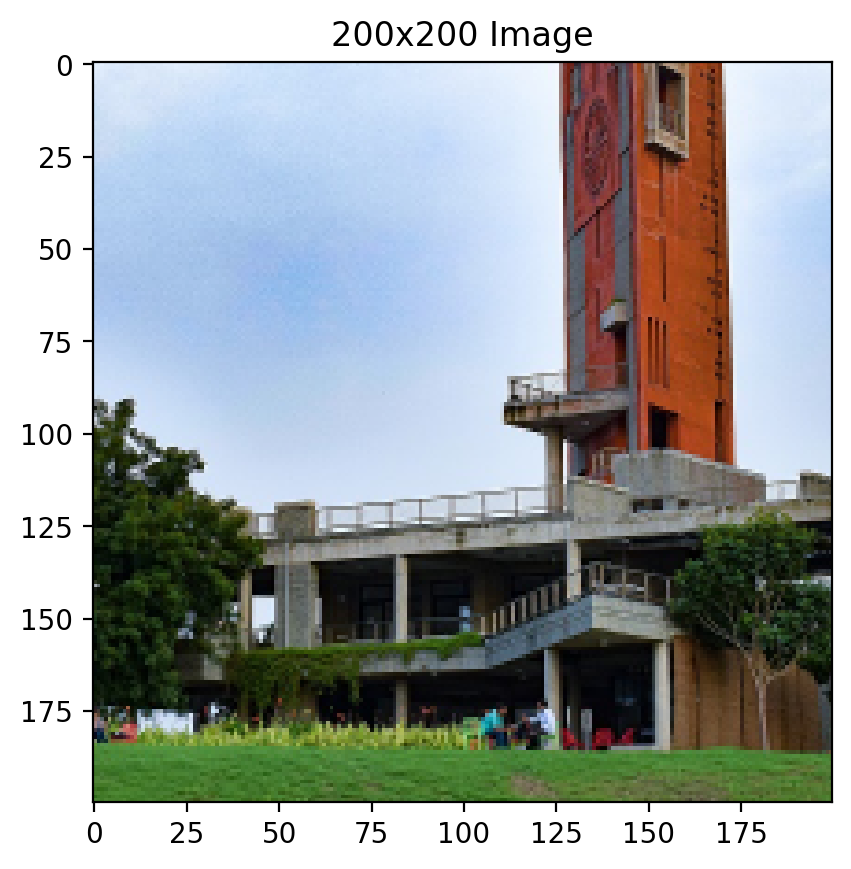

In [ ]:
plt.imshow(rearrange(resized_crop, 'c h w -> h w c').cpu().numpy())
# plt.axis('off')
plt.title("200x200 Image")
plt.show()

## Create a coordinate map

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    print("Number of channels:", num_channels, "\nHeight:", height, "\nWidth:", width)
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    print("-"*50)

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
    print("X shape:", X.shape)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    print("Y shape:", Y.shape)

    return X, Y

### Functions to Calculate RMSE and PSNR

In [ ]:
def calculate_metrics(original_image, reconstructed_image, max_pixel_value=1.0):
    """
    Calculate RMSE and PSNR between the original and reconstructed images.

    Parameters:
    - original_image (torch.Tensor): The original image tensor.
    - reconstructed_image (torch.Tensor): The reconstructed image tensor.
    - max_pixel_value (float): The maximum pixel value for PSNR calculation.

    Returns:
    - rmse (float): The Root Mean Squared Error.
    - psnr (float): The Peak Signal-to-Noise Ratio.
    """
    # Ensure the images are on the same device
    original_image = original_image.to(reconstructed_image.device)

    # Calculate RMSE
    mse = torch.mean((original_image - reconstructed_image) ** 2)
    rmse = torch.sqrt(mse).item()

    # Calculate PSNR
    if mse == 0:  # MSE is zero means images are identical
        psnr = float('inf')
    else:
        psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse)).item()

    return rmse, psnr


### Defining Linear Model

In [ ]:
# linear Regression - neural  network with one input and output layer - no hidden layers
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        # Define a linear transformation
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

In [ ]:
'''
Efficient Approach - Saves precision
for epoch in range(1, epochs+1):
    optimizer.zero_grad()  # Clears old gradients

    with autocast():
        outputs = net(X)
        loss = criterion(outputs, Y)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    losses.append(loss.item())

    if verbose and epoch % 200 == 0:
        print(f"Epoch {epoch} loss: {loss.item():.6f}")

'''

def train(net, lr, X, Y, epochs, batch_size=None, mini_batch=False, verbose=True,loss_change_threshold=1e-20,patience=10):

    criterion = nn.MSELoss()  # Loss function
    optimizer = optim.Adam(net.parameters(), lr=lr)  # Optimizer

    losses = []
    print("Start Training")

    if mini_batch:
        print("Performing mini-batch gradient descent")
        # Mini-Batch Gradient Descent
        dataset = TensorDataset(X, Y)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(1, epochs+1):
            epoch_loss = 0
            for batch_X, batch_Y in data_loader:
                optimizer.zero_grad()  # Clears old gradients
                output = net(batch_X)  # Forward pass
                loss = criterion(output, batch_Y)  # Compute loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update weights

                epoch_loss += loss.item()

            losses.append(epoch_loss / len(data_loader))

            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch} loss: {epoch_loss / len(data_loader)}")

    else:
        print("Performing single-batch gradient descent")
        no_improvement =0
        # Single-Batch Gradient Descent
        for epoch in range(1,epochs+1):
            optimizer.zero_grad()  # Clears old gradients
            outputs = net(X)  # Forward pass

            loss = criterion(outputs, Y)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            if verbose and (epoch)% 100 == 0:
                print(f"Epoch {epoch} loss: {loss.item():.6f}")

            losses.append(loss.item())

            if len(losses) > 1:
                loss_change = abs(losses[-1] - losses[-2])
                if loss_change < loss_change_threshold:
                    no_improvement += 1
                else:
                    no_improvement = 0

                if no_improvement > patience:
                    print(f"No significant improvement for {patience} epochs. Stopping training at epoch:{epoch}.")
                    break


    # Clear unused memory
    torch.cuda.empty_cache()
    print(f"Training Completed, Final loss = {losses[-1]}")
    return losses


In [ ]:

def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient computation to save memory and computation
        outputs = net(X) # Perform forward pass without tracking gradients and get outputs
        outputs = outputs.reshape(height, width, num_channels)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu()) #Show reconstructed image
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0)) # Show original image (permute channels)
    ax1.set_title("Original Image")

    # for a in [ax0, ax1]:
    #     a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

    # Convert outputs to PyTorch tensor
    outputs_tensor = torch.tensor(outputs).permute(2, 0, 1).unsqueeze(0).to(device)
    print("Output shape:",outputs_tensor.shape)
    # Calculate metrics
    rmse, psnr = calculate_metrics(original_img, outputs_tensor)
    print(f"RMSE: {rmse:.4f}")
    print(f"PSNR: {psnr:.2f} dB")

    return rmse,psnr

In [ ]:
def normalize_image(image):
    """Normalize image to [0, 1] range for float images."""
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) / (image_max - image_min)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def apply_sigmoid(image_tensor):
    """Apply sigmoid to image tensor to normalize it to [0, 1] range."""
    return sigmoid(image_tensor)

def clip(image_tensor):
    """Clip image tensor to [0, 1] range."""
    return torch.clamp(image_tensor, 0, 1)


In [ ]:
import gc
import os
import psutil
import torch

def print_memory_usage():
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    print(f"Memory Usage: {memory_info.rss / 1024 ** 2:.2f} MB")

def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()
    print_memory_usage()

# Call this function to print and clear memory
clear_memory()


Memory Usage: 452.39 MB


In [ ]:
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler

torch.cuda.empty_cache()
# create RFF features
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [ ]:
img_X, img_Y = create_coordinate_map(resized_crop)

print("-"*50)
print(img_X) # (300*300, 2)- coordinates
print(img_X.shape)
print(img_Y) # (300*300, 3)- RGB values
print(img_Y.shape)


# MinMaxScaler from -1 to 1 - helps in numerical calculation while training neural network
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())

# Scale the X coordinates
img_X_scaled = scaler_X.transform(img_X.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled = torch.tensor(img_X_scaled).to(device)

# Set to dtype float32
img_X_scaled = img_X_scaled.float()

print(img_X_scaled)

Number of channels: 3 
Height: 200 
Width: 200
--------------------------------------------------
X shape: torch.Size([40000, 2])
Y shape: torch.Size([40000, 3])
--------------------------------------------------
tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]])
torch.Size([40000, 2])
tensor([[0.8912, 0.9382, 0.9853],
        [0.8853, 0.9324, 0.9814],
        [0.8902, 0.9373, 0.9971],
        ...,
        [0.3049, 0.4804, 0.1961],
        [0.3284, 0.5167, 0.2157],
        [0.3039, 0.4873, 0.1794]])
torch.Size([40000, 3])
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9899],
        [-1.0000, -0.9799],
        ...,
        [ 1.0000,  0.9799],
        [ 1.0000,  0.9899],
        [ 1.0000,  1.0000]])


torch.Size([40000, 37500])
Start Training
Performing single-batch gradient descent
Epoch 100 loss: 0.079817
Epoch 200 loss: 0.043800
Epoch 300 loss: 0.031082
Epoch 400 loss: 0.022704
Epoch 500 loss: 0.016782
Epoch 600 loss: 0.012491
Epoch 700 loss: 0.009341
Epoch 800 loss: 0.007015
Epoch 900 loss: 0.005292
Epoch 1000 loss: 0.004018
Epoch 1100 loss: 0.003078
Epoch 1200 loss: 0.002390
Epoch 1300 loss: 0.001890
Epoch 1400 loss: 0.001530
Epoch 1500 loss: 0.001275
Epoch 1600 loss: 0.001095
Epoch 1700 loss: 0.000971
Epoch 1800 loss: 0.000886
Epoch 1900 loss: 0.000829
Epoch 2000 loss: 0.000791
Epoch 2100 loss: 0.000766
Epoch 2200 loss: 0.000750
Epoch 2300 loss: 0.000739
Epoch 2400 loss: 0.000733
Epoch 2500 loss: 0.000728
Epoch 2600 loss: 0.000725
Epoch 2700 loss: 0.000722
Epoch 2800 loss: 0.000721
Epoch 2900 loss: 0.000719
Epoch 3000 loss: 0.000718
Epoch 3100 loss: 0.000716
Epoch 3200 loss: 0.000715
Epoch 3300 loss: 0.000714
Epoch 3400 loss: 0.000713
Epoch 3500 loss: 0.000713
Epoch 3600 loss:

Epoch 5000 loss: 0.000703
Training Completed, Final loss = 0.0007033935398794711
Output shape: torch.Size([1, 3, 200, 200])
RMSE: 0.0265
PSNR: 31.53 dB


(0.026521485116971576, 31.528043210136346)

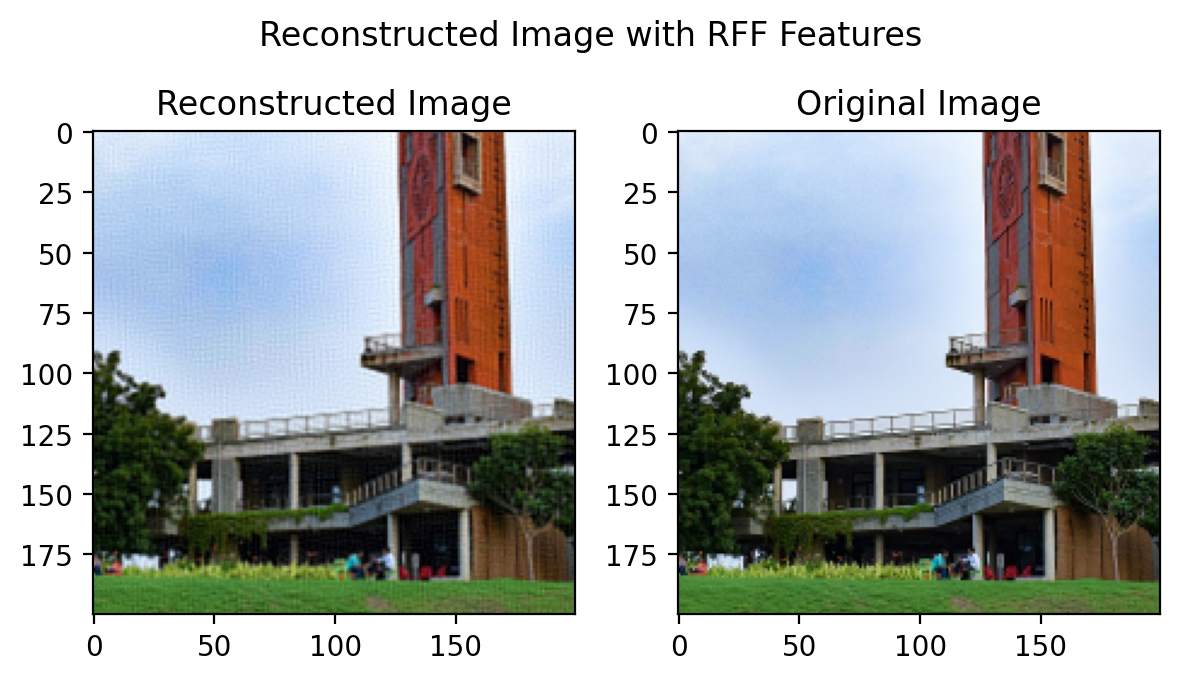

In [ ]:
X_rff = create_rff_features(img_X_scaled, 37500, 0.008)
print(X_rff.shape)

net_rff = LinearModel(X_rff.shape[1],3)
net_rff.to(device)

losses_rff = train(net_rff, lr=0.005, X=X_rff, Y=img_Y, epochs=5000, verbose=True)
plot_reconstructed_and_original_image(resized_crop, net_rff, X_rff, title="Reconstructed Image with RFF Features")
# del net_rff,losses_rff,X_rff


In [ ]:
img_X_hr, img_Y_hr = create_coordinate_map(crop)
img_X_hr = img_X_hr /2.0
print("-"*50)

print(img_X)
print(img_X.shape)

print(img_X_hr) # (300*300, 2)- coordinates
print(img_X_hr.shape)

# Scale the X coordinates
img_X_scaled_hr = scaler_X.transform(img_X_hr.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled_hr = torch.tensor(img_X_scaled_hr).to(device)

# Set to dtype float32
img_X_scaled_hr = img_X_scaled_hr.float()


print(img_X_scaled)
print("-"*50)
print(img_X_scaled_hr)


Number of channels: 3 
Height: 400 
Width: 400
--------------------------------------------------
X shape: torch.Size([160000, 2])
Y shape: torch.Size([160000, 3])
--------------------------------------------------
tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]])
torch.Size([40000, 2])
tensor([[  0.0000,   0.0000],
        [  0.0000,   0.5000],
        [  0.0000,   1.0000],
        ...,
        [199.5000, 198.5000],
        [199.5000, 199.0000],
        [199.5000, 199.5000]])
torch.Size([160000, 2])
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9899],
        [-1.0000, -0.9799],
        ...,
        [ 1.0000,  0.9799],
        [ 1.0000,  0.9899],
        [ 1.0000,  1.0000]])
--------------------------------------------------
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9899],
        ...,
        [ 1.0050,  0.9950],
        [ 1.0050,  1.0000],
        [ 1.

torch.Size([160000, 37500])


Output shape: torch.Size([1, 3, 400, 400])
RMSE: 0.6652
PSNR: 3.54 dB


(0.6651820938913948, 3.5411890023043426)

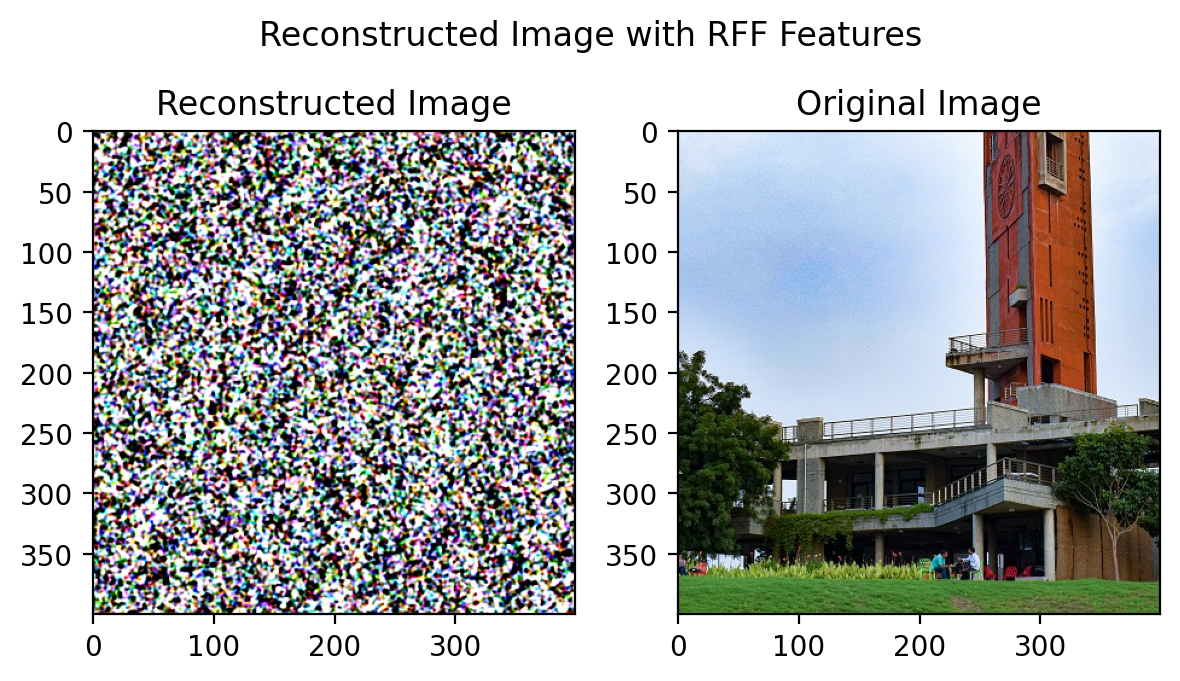

In [ ]:
X_rff_hr = create_rff_features(img_X_scaled_hr, 37500, 0.008)
print(X_rff_hr.shape)

plot_reconstructed_and_original_image(original_img = crop,net = net_rff,X = X_rff_hr, title="Reconstructed Image with RFF Features")

## The right way

In [ ]:
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler

torch.cuda.empty_cache()
# create RFF features
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2),random_state = 42) # SETTING UP RANDOM STATE
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


torch.Size([40000, 37500])
Start Training
Performing single-batch gradient descent
Epoch 100 loss: 0.083757
Epoch 200 loss: 0.047233
Epoch 300 loss: 0.033559
Epoch 400 loss: 0.024350
Epoch 500 loss: 0.017765
Epoch 600 loss: 0.012976
Epoch 700 loss: 0.009476
Epoch 800 loss: 0.006920
Epoch 900 loss: 0.005064
Epoch 1000 loss: 0.003726
Epoch 1100 loss: 0.002772
Epoch 1200 loss: 0.002101
Epoch 1300 loss: 0.001636
Epoch 1400 loss: 0.001317
Epoch 1500 loss: 0.001104
Epoch 1600 loss: 0.000962
Epoch 1700 loss: 0.000870
Epoch 1800 loss: 0.000812
Epoch 1900 loss: 0.000775
Epoch 2000 loss: 0.000752
Epoch 2100 loss: 0.000738
Epoch 2200 loss: 0.000729
Epoch 2300 loss: 0.000723
Epoch 2400 loss: 0.000719
Epoch 2500 loss: 0.000716
Epoch 2600 loss: 0.000714
Epoch 2700 loss: 0.000713
Epoch 2800 loss: 0.000711
Epoch 2900 loss: 0.000710
Epoch 3000 loss: 0.000708
Epoch 3100 loss: 0.000707
Epoch 3200 loss: 0.000706
Epoch 3300 loss: 0.000705
Epoch 3400 loss: 0.000704
Epoch 3500 loss: 0.000703
Epoch 3600 loss:

Epoch 5000 loss: 0.000693
Training Completed, Final loss = 0.00069275131681934
Output shape: torch.Size([1, 3, 200, 200])
RMSE: 0.0263
PSNR: 31.59 dB


(0.0263200726680104, 31.594258319951642)

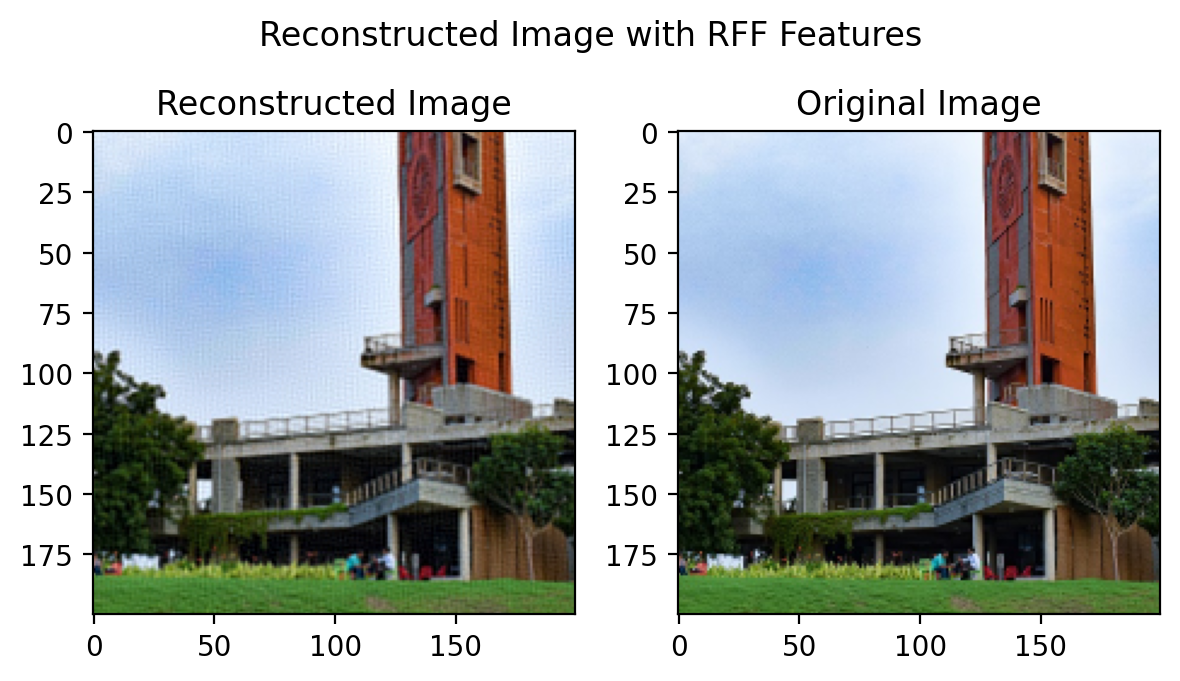

In [ ]:
X_rff = create_rff_features(img_X_scaled, 37500, 0.008)
print(X_rff.shape)

net_rff = LinearModel(X_rff.shape[1],3)
net_rff.to(device)

losses_rff = train(net_rff, lr=0.005, X=X_rff, Y=img_Y, epochs=5000, verbose=True)
plot_reconstructed_and_original_image(resized_crop, net_rff, X_rff, title="Reconstructed Image with RFF Features")
# del net_rff,losses_rff,X_rff


In [ ]:
img_X_hr, img_Y_hr = create_coordinate_map(crop)
img_X_hr = img_X_hr /2.0
print("-"*50)

print(img_X)
print(img_X.shape)

print(img_X_hr) # (300*300, 2)- coordinates
print(img_X_hr.shape)

# Scale the X coordinates
img_X_scaled_hr = scaler_X.transform(img_X_hr.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled_hr = torch.tensor(img_X_scaled_hr).to(device)

# Set to dtype float32
img_X_scaled_hr = img_X_scaled_hr.float()


print(img_X_scaled)
print("-"*50)
print(img_X_scaled_hr)


Number of channels: 3 
Height: 400 
Width: 400
--------------------------------------------------
X shape: torch.Size([160000, 2])
Y shape: torch.Size([160000, 3])
--------------------------------------------------
tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]])
torch.Size([40000, 2])
tensor([[  0.0000,   0.0000],
        [  0.0000,   0.5000],
        [  0.0000,   1.0000],
        ...,
        [199.5000, 198.5000],
        [199.5000, 199.0000],
        [199.5000, 199.5000]])
torch.Size([160000, 2])
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9899],
        [-1.0000, -0.9799],
        ...,
        [ 1.0000,  0.9799],
        [ 1.0000,  0.9899],
        [ 1.0000,  1.0000]])
--------------------------------------------------
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9899],
        ...,
        [ 1.0050,  0.9950],
        [ 1.0050,  1.0000],
        [ 1.

torch.Size([160000, 37500])


Output shape: torch.Size([1, 3, 400, 400])
RMSE: 0.0808
PSNR: 21.85 dB


(0.08078616336954324, 21.853260330754782)

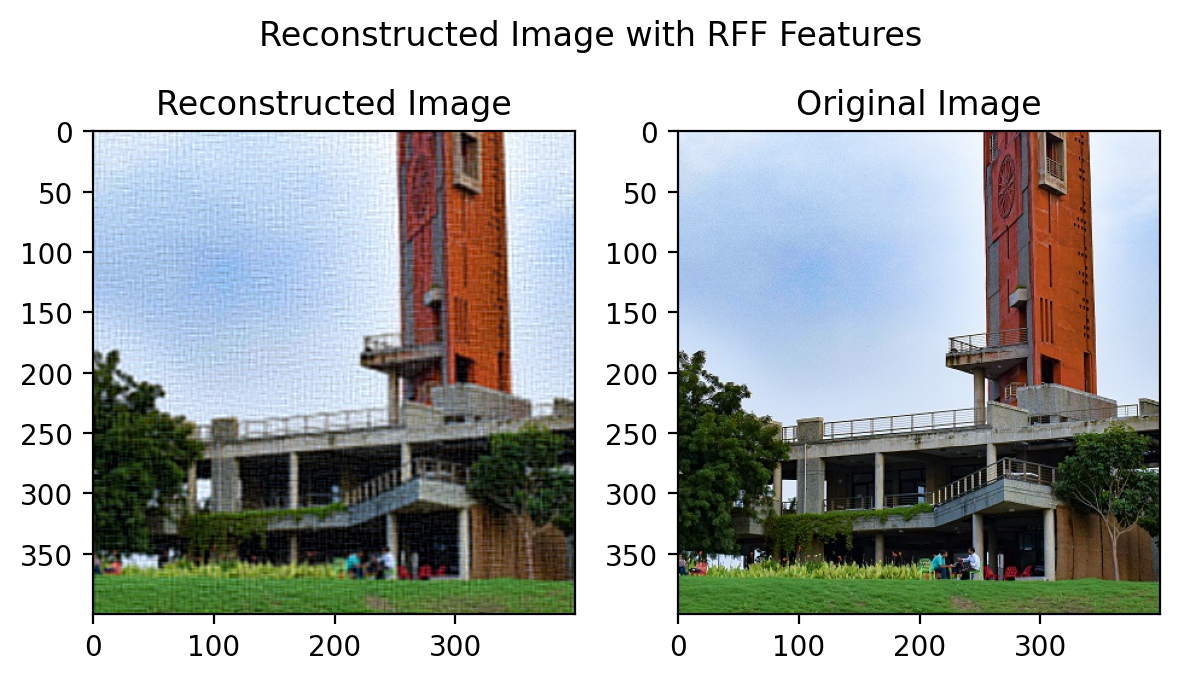

In [ ]:
X_rff_hr = create_rff_features(img_X_scaled_hr, 37500, 0.008)
print(X_rff_hr.shape)

plot_reconstructed_and_original_image(original_img = crop,net = net_rff,X = X_rff_hr, title="Reconstructed Image with RFF Features")

## The more right way

The "better" way would be to not scale the coordinate map , this will the perfect scaling result . But this leads to another issue that the since the scaling is not done , the initial model itself is not trained well enough . So the original reconstruction is also a bit poor ... 

In [ ]:
img_X, img_Y = create_coordinate_map(resized_crop)

print("-"*50)
print(img_X) # (300*300, 2)- coordinates
print(img_X.shape)
print(img_Y) # (300*300, 3)- RGB values
print(img_Y.shape)


X_rff_2 = create_rff_features(img_X, 37500, 0.008)
print(X_rff.shape)

net_rff_2 = LinearModel(X_rff_2.shape[1],3)
net_rff_2.to(device)

losses_rff = train(net_rff, lr=0.005, X=X_rff, Y=img_Y, epochs=5000, verbose=True)
plot_reconstructed_and_original_image(resized_crop, net_rff_2, X_rff_2, title="Reconstructed Image with RFF Features")


Number of channels: 3 
Height: 200 
Width: 200
--------------------------------------------------
X shape: torch.Size([40000, 2])
Y shape: torch.Size([40000, 3])
--------------------------------------------------
tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]])
torch.Size([40000, 2])
tensor([[0.8912, 0.9382, 0.9853],
        [0.8853, 0.9324, 0.9814],
        [0.8902, 0.9373, 0.9971],
        ...,
        [0.3049, 0.4804, 0.1961],
        [0.3284, 0.5167, 0.2157],
        [0.3039, 0.4873, 0.1794]])
torch.Size([40000, 3])
torch.Size([40000, 37500])
Start Training
Performing single-batch gradient descent
Epoch 100 loss: 0.000692
Epoch 200 loss: 0.000692


In [ ]:
img_X_hr_2, img_Y_hr_2 = create_coordinate_map(crop)
img_X_hr_2 = img_X / 2.0
print("-"*50)

print(img_X)
print(img_X.shape)

print(img_X_hr_2) # (300*300, 2)- coordinates
print(img_X_hr_2.shape)

In [ ]:
img_X_hr_2, img_Y_hr_2 = create_coordinate_map(crop)
img_X_hr_2 = img_X / 2.0
print("-"*50)

print(img_X)
print(img_X.shape)

print(img_X_hr_2) # (300*300, 2)- coordinates
print(img_X_hr_2.shape)

In [ ]:
torch.cuda.empty_cache()

### **PSNR (Peak Signal-to-Noise Ratio) and SNR (Signal-to-Noise Ratio)**

**1. PSNR (Peak Signal-to-Noise Ratio):**

- **Purpose:** PSNR is a metric used to measure the quality of reconstructed or compressed images compared to the original image. It evaluates how much the reconstructed image deviates from the original image in terms of pixel values.

- **Calculation Steps:**
  1. **Compute the Mean Squared Error (MSE):**
     \[
     \text{MSE} = \frac{1}{M \times N} \sum_{i=1}^M \sum_{j=1}^N (I(i, j) - K(i, j))^2
     \]
     where \(I\) is the original image, \(K\) is the reconstructed image, and \(M\) and \(N\) are the dimensions of the image.

  2. **Calculate the Peak Signal-to-Noise Ratio (PSNR):**
     \[
     \text{PSNR} = 10 \times \log_{10} \left(\frac{R^2}{\text{MSE}}\right)
     \]
     where \(R\) is the maximum possible pixel value (e.g., 255 for an 8-bit image).

**2. SNR (Signal-to-Noise Ratio):**

- **Purpose:** SNR is a metric used to measure the quality of audio signals or any signal where you compare the signal strength to the background noise. It evaluates how much the useful signal is drowned out by the noise.

- **Calculation Steps:**
  1. **Compute the Signal Power (P_signal):**
     $$\[
     P_{\text{signal}} = \frac{1}{N} \sum_{i=1}^N x(i)^2
     \]$$
     where \(x(i)\) represents the signal samples and \(N\) is the number of samples.

  2. **Compute the Noise Power (P_noise):**
     $\[
     P_{\text{noise}} = \frac{1}{N} \sum_{i=1}^N n(i)^2
     \]$
     where \(n(i)\) represents the noise samples.

  3. **Calculate the Signal-to-Noise Ratio (SNR):**
     $\[
     \text{SNR} = 10 \times \log_{10} \left(\frac{P_{\text{signal}}}{P_{\text{noise}}}\right)
     \]$

### Summary

- **PSNR** is used for images to measure how much the reconstructed image deviates from the original image, focusing on pixel-level errors.
- **SNR** is used for audio signals (or other types of signals) to quantify the ratio of the signal power to the noise power, assessing the quality of the signal relative to background noise.
